In [1]:
from astroquery.mast import Observations
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.wcs import WCS
from drizzlepac import astrodrizzle
import h5axeconfig
import h5py
import pandas as pd

import glob

from scipy.optimize import curve_fit
import scipy.signal
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

RA = '13h9m48.085s'
DEC = '-23d22m53.3s'
COORD = SkyCoord(RA,DEC)
COORD

The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       imagefindpars           mapreg              photeq       
     pixreplace           pixtopix            pixtosky        refimagefindpars  
     resetbits          runastrodriz          skytopix           tweakback      
      tweakreg           updatenpol


<SkyCoord (ICRS): (ra, dec) in deg
    (197.45035417, -23.38147222)>

In [2]:
def polynomial(x,A,B,C):
    return A + B*x + C*x*x

def grismTrace(x,D,E,F):
    return D * np.exp(-0.5 * ((x-E)/F)**2)

def totalGaussianFlux(D,E,F):
    return np.sqrt(2. * np.pi * F**2) * D

# Download

In [3]:
obsid = {'F110W': ('idp7g1010','170822')
        ,'G102': ('idp7g1020','170822')}

for i in obsid:
    x = Observations.query_criteria(obs_id=obsid[i][0])
    Observations.download_products(x['obsid']
                                   ,productSubGroupDescription=['FLT']
                                  ,download_dir='./{0}/{1}/'.format(obsid[i][1],i))

INFO: Found cached file ./170822/F110W/mastDownload/HST/idp7g1ggq/idp7g1ggq_flt.fits with expected size 16534080. [astroquery.query]
INFO: Found cached file ./170822/F110W/mastDownload/HST/idp7g1gkq/idp7g1gkq_flt.fits with expected size 16534080. [astroquery.query]
INFO: Found cached file ./170822/F110W/mastDownload/HST/idp7g1glq/idp7g1glq_flt.fits with expected size 16534080. [astroquery.query]
INFO: Found cached file ./170822/G102/mastDownload/HST/idp7g1h2q/idp7g1h2q_flt.fits with expected size 16534080. [astroquery.query]
INFO: Found cached file ./170822/G102/mastDownload/HST/idp7g1h4q/idp7g1h4q_flt.fits with expected size 16534080. [astroquery.query]
INFO: Found cached file ./170822/G102/mastDownload/HST/idp7g1h5q/idp7g1h5q_flt.fits with expected size 16534080. [astroquery.query]
INFO: Found cached file ./170822/G102/mastDownload/HST/idp7g1h7q/idp7g1h7q_flt.fits with expected size 16534080. [astroquery.query]


In [4]:
g141_files = glob.glob('./170822/G102/*/*/*/*flt.fits')
f160w_files = glob.glob('./170822/F110W/*/*/*/*flt.fits')

print(g141_files)
print('###############')
print(f160w_files)

['./170822/G102/mastDownload/HST/idp7g1h7q/idp7g1h7q_flt.fits', './170822/G102/mastDownload/HST/idp7g1h4q/idp7g1h4q_flt.fits', './170822/G102/mastDownload/HST/idp7g1h2q/idp7g1h2q_flt.fits', './170822/G102/mastDownload/HST/idp7g1h5q/idp7g1h5q_flt.fits']
###############
['./170822/F110W/mastDownload/HST/idp7g1ggq/idp7g1ggq_flt.fits', './170822/F110W/mastDownload/HST/idp7g1gkq/idp7g1gkq_flt.fits', './170822/F110W/mastDownload/HST/idp7g1glq/idp7g1glq_flt.fits']


POSTARG of ./170822/G102/mastDownload/HST/idp7g1h7q/idp7g1h7q_flt.fits: -0.2034 0.3030
POSTARG of ./170822/G102/mastDownload/HST/idp7g1h4q/idp7g1h4q_flt.fits: 0.5423 0.1818
POSTARG of ./170822/G102/mastDownload/HST/idp7g1h2q/idp7g1h2q_flt.fits: 0.0000 0.0000
POSTARG of ./170822/G102/mastDownload/HST/idp7g1h5q/idp7g1h5q_flt.fits: 0.3389 0.4848


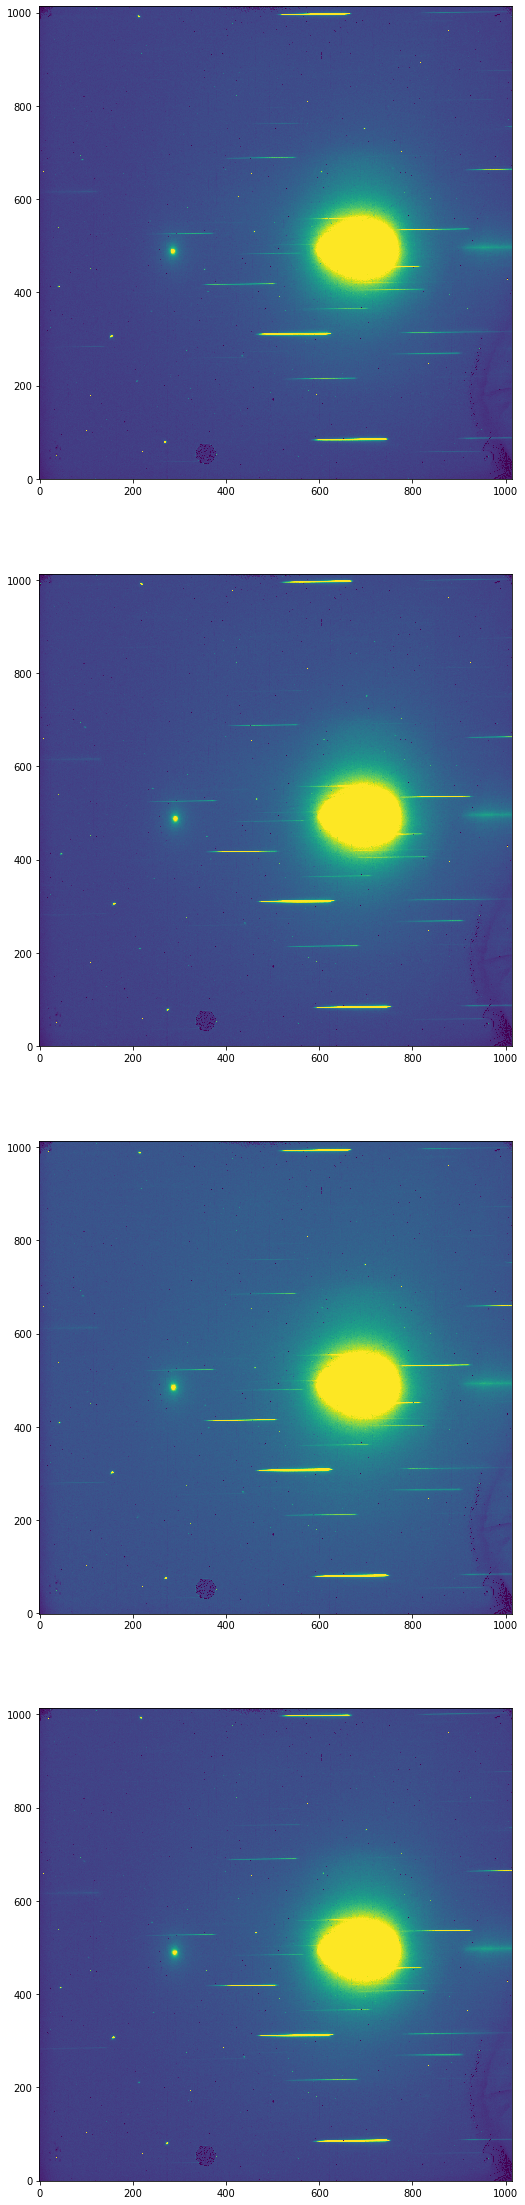

In [5]:
n = len(g141_files)
fig,ax = plt.subplots(n,1,figsize=(10,10*n))
for i in np.arange(n):
    x = fits.open(g141_files[i])
    ax[i].imshow(x['SCI'].data,origin='lower',cmap='viridis',vmin=0,vmax=10)
    print('POSTARG of {0}: {1:.4f} {2:.4f}'.format(g141_files[i],x[0].header['POSTARG1'],x[0].header['POSTARG2']))

POSTARG of ./170822/G102/mastDownload/HST/idp7g1h7q/idp7g1h7q_flt.fits: 0.0000 0.0000
POSTARG of ./170822/G102/mastDownload/HST/idp7g1h4q/idp7g1h4q_flt.fits: 0.4511 0.4032
POSTARG of ./170822/G102/mastDownload/HST/idp7g1h2q/idp7g1h2q_flt.fits: 0.9022 0.8063


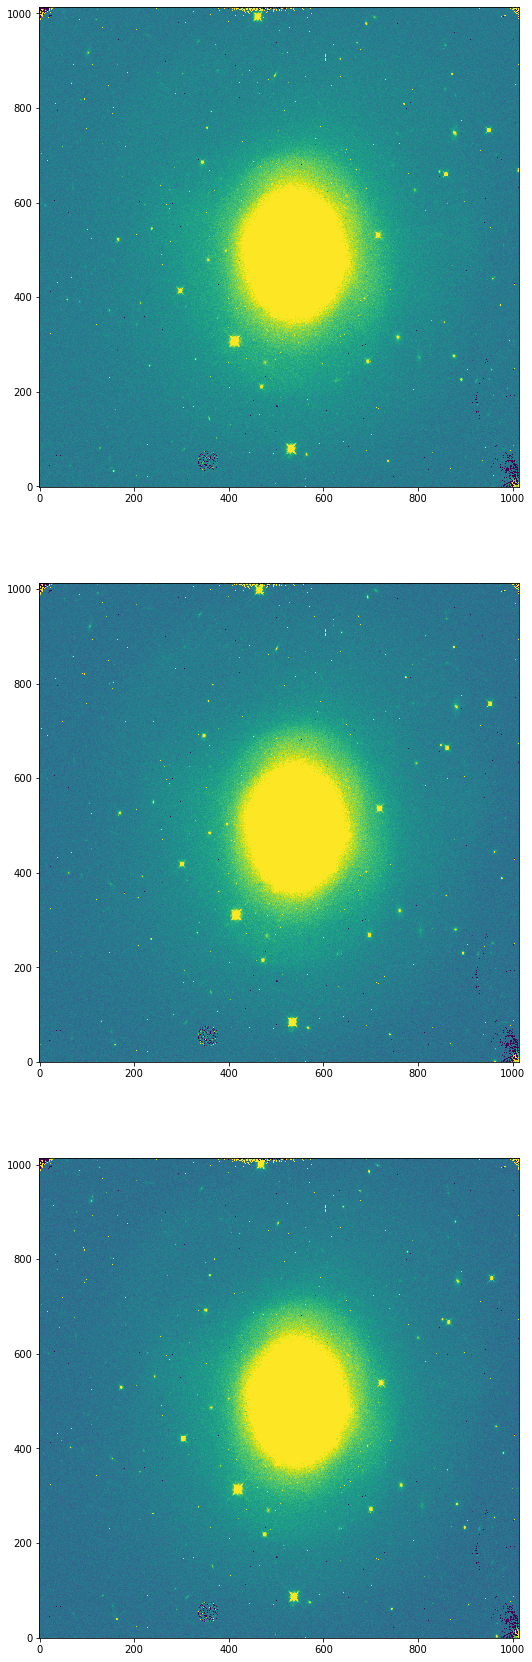

In [6]:
n = len(f160w_files)
fig,ax = plt.subplots(n,1,figsize=(10,10*n))
for i in np.arange(n):
    x = fits.open(f160w_files[i])
    ax[i].imshow(x['SCI'].data,origin='lower',cmap='viridis',vmin=0,vmax=10)
    print('POSTARG of {0}: {1:.4f} {2:.4f}'.format(g141_files[i],x[0].header['POSTARG1'],x[0].header['POSTARG2']))

# Drizzle

In [7]:
# G102
# final_kernel = 'square'
final_kernel = 'gaussian'
combine_type = 'median'
final_pixfrac = 0.6
final_scale = None
astrodrizzle.AstroDrizzle(g141_files
                          ,output="./170822/G102/g102"
                          ,build=True
                          ,clean=True
                          ,skysub='yes'
                          ,final_wcs=True
                          ,final_kernel=final_kernel
                         ,final_pixfrac=final_pixfrac
                         ,final_scale=final_scale
                         ,final_outnx=1014
                         ,final_outny=1014
                         ,combine_type=combine_type)


Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 3.0.2 (2019-05-28 16:51:22 -0400) started at: 09:31:35.769 (26/08/2019)

==== Processing Step  Initialization  started at  09:31:35.772 (26/08/2019)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 197.44995652705322  -23.38296778205653  
CRPIX : 507.5  507.5  
CD1_1 CD1_2  : -3.508378712392043e-05  -6.186158959148004e-06  
CD2_1 CD2_2  : -6.186158959148004e-06  3.508378712392043e-05  
NAXIS : 1014  1014
********************************************************************************
*
*  Estimated memory usage:  up to 78 Mb.
*  Output image size:       1014 X 1014 pixels. 
*  Output image file:       ~ 11 Mb. 
*  Cores available:         4
*
********************************************************************************
==== Processing Step  Initialization  finished at  09:31:36.356 (26/08/2019)

==== Processing Step  Static Mask  started at  09:31:36.360 (26/08/2019)
==== Processing Step  Static 

Writing out image to disk: /Users/kbhirombhakdi/_work/_G280_reduction/170822/G102/mastDownload/HST/idp7g1h2q/idp7g1h2q_sci1_blt.fits
    Blot: creating blotted image:  /Users/kbhirombhakdi/_work/_G280_reduction/170822/G102/mastDownload/HST/idp7g1h5q/idp7g1h5q_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: /Users/kbhirombhakdi/_work/_G280_reduction/170822/G102/mastDownload/HST/idp7g1h5q/idp7g1h5q_sci1_blt.fits
Writing out image to disk: /Users/kbhirombhakdi/_work/_G280_reduction/170822/G102/mastDownload/HST/idp7g1h5q/idp7g1h5q_sci1_blt.fits
==== Processing Step  Blot  finished at  09:31:39.994 (26/08/2019)

==== Processing Step  Driz_CR  started at  09:31:39.996 (26/08/2019)
Creating output: /Users/kbhirombhakdi/_work/_G280_reduction/170822/G102/mastDownload/HST/idp7g1h7q/idp7g1h7q_sci1_crmask.fits
Creating output: /Users/kbhirombhakdi/_work/_G280_reduction/170822/G102/mastDownload/HST/idp7g1h4q/idp7g1h4q_sci1_crmask.fits
Creating outp

In [8]:
# F110W
final_kernel = 'gaussian'
final_pixfrac = 0.6
final_scale = None
astrodrizzle.AstroDrizzle(f160w_files
                          ,output="./170822/F110W/f110w"
                          ,build=True
                          ,clean=True
                          ,skysub='yes'
                          ,final_wcs=True
                          ,final_kernel=final_kernel
                         ,final_pixfrac=final_pixfrac
                         ,final_scale=final_scale
                         ,final_outnx=1014
                         ,final_outny=1014
                         ,final_refimage='./170822/G102/g102_drz.fits')

Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 3.0.2 (2019-05-28 16:51:22 -0400) started at: 09:31:43.577 (26/08/2019)

==== Processing Step  Initialization  started at  09:31:43.580 (26/08/2019)
Creating OUTPUT WCS from ./170822/G102/g102_drz.fits[1]
WCS Keywords

CD_11  CD_12: -3.508378712392e-05 -6.186158959148e-06
CD_21  CD_22: -6.186158959148e-06 3.50837871239204e-05
CRVAL    : 197.4499565270532 -23.38296778205653
CRPIX    : 507.5 507.5
NAXIS    : 1014 1014
Plate Scale : 0.12825000286102137
ORIENTAT : -9.999906082548089
********************************************************************************
*
*  Estimated memory usage:  up to 58 Mb.
*  Output image size:       1014 X 1014 pixels. 
*  Output image file:       ~ 11 Mb. 
*  Cores available:         3
*
********************************************************************************
==== Processing Step  Initialization  finished at  09:31:44.083 (26/08/2019)

==== Processing Step  Static Mask  started at  09:31:4

CRVAL    : 197.4499565270532 -23.38296778205653
CRPIX    : 507.5 507.5
NAXIS    : 1014 1014
Plate Scale : 0.12825000286102137
ORIENTAT : -9.999906082548089
-Generating multi-extension output file:  ./170822/F110W/f110w_drz.fits
Writing out to disk: ./170822/F110W/f110w_drz.fits
==== Processing Step  Final Drizzle  finished at  09:31:50.43 (26/08/2019)


AstroDrizzle Version 3.0.2 is finished processing at 09:31:50.433 (26/08/2019).


   --------------------          --------------------
                   Step          Elapsed time
   --------------------          --------------------

         Initialization          0.5037 sec.
            Static Mask          0.0923 sec.
           Subtract Sky          0.4090 sec.
       Separate Drizzle          1.0322 sec.
          Create Median          0.5753 sec.
                   Blot          1.0645 sec.
                Driz_CR          1.0867 sec.
          Final Drizzle          2.0571 sec.
   ====================          ==============

In [9]:
x = fits.open('./170822/G102/g102_drz.fits')
w = WCS(x['SCI'])
x0,y0 = w.all_world2pix(COORD.ra,COORD.dec,1)
print('GW170817 x0,y0: {0:.3f}, {1:.3f}'.format(x0,y0))

GW170817 x0,y0: 490.121, 547.064


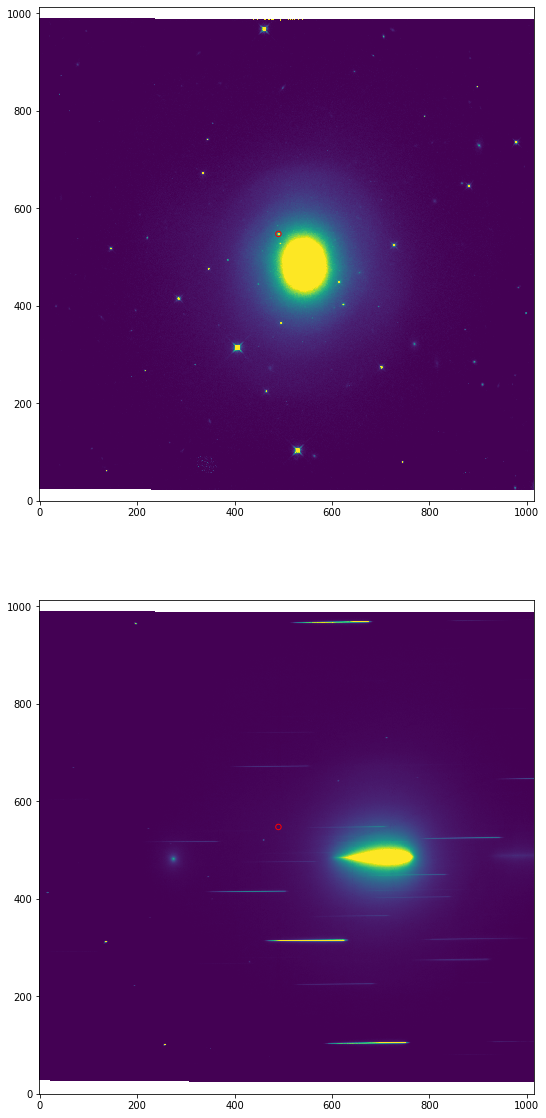

In [10]:
fig,ax = plt.subplots(2,1,figsize=(10,20))

ax[0].imshow(fits.open('./170822/F110W/f110w_drz.fits')['SCI'].data
            ,origin='lower'
            ,cmap='viridis'
            ,vmin=0,vmax=30)
ax[0].scatter(x0,y0,s=30,edgecolor='r',facecolor='None')

ax[1].imshow(fits.open('./170822/G102/g102_drz.fits')['SCI'].data
            ,origin='lower'
            ,cmap='viridis'
            ,vmin=0,vmax=30)
ax[1].scatter(x0,y0,s=30,edgecolor='r',facecolor='None')

# Stamp of spectrum

In [11]:
dx = 250
dy = 15

x0=np.int(x0)
y0=np.int(y0)

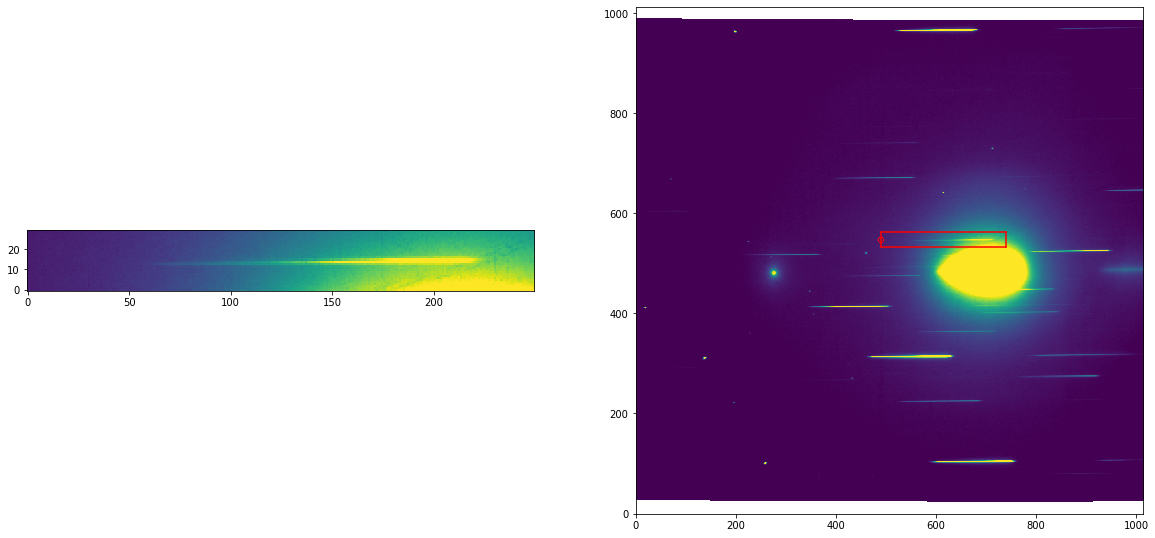

In [12]:
fig,ax = plt.subplots(1,2,figsize=(20,10))

x = fits.open('./170822/G102/g102_drz.fits')['SCI'].data
gxy = x[y0-dy:y0+dy,x0:x0+dx]

ax[0].imshow(gxy,cmap='viridis',origin='lower',vmin=0,vmax=10)
ax[1].imshow(x,cmap='viridis',origin='lower',vmin=0,vmax=10)

ax[1].plot([x0,x0+dx],[y0-dy,y0-dy],color='red')
ax[1].plot([x0,x0+dx],[y0+dy,y0+dy],color='red')
ax[1].plot([x0,x0],[y0-dy,y0+dy],color='red')
ax[1].plot([x0+dx,x0+dx],[y0-dy,y0+dy],color='red')
ax[1].scatter(x0,y0,s=30,edgecolor='r',facecolor='None')

plt.show()

# Background Model

Area in between the lines will be masked out for fitting the background model.


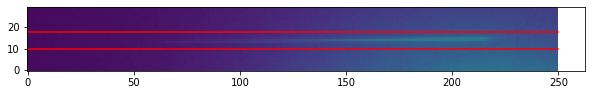

In [13]:
# masking out the spectral trace
dd = 4 # mask width from y-center
y_adjust = -1 # arbitrarily adjust y-center for the mask
mask_min=dy-dd+y_adjust
mask_max=dy+dd+y_adjust

plt.figure(figsize=(10,10))
plt.imshow(gxy,cmap='viridis',origin='lower',vmin=0,vmax=30)
plt.plot([0,dx],[mask_min,mask_min],color='r')
plt.plot([0,dx],[mask_max,mask_max],color='r')
print('Area in between the lines will be masked out for fitting the background model.')

In [14]:
# fit background with masking out the trace
coef = {}
init = [1.,0.,0.]
for i in np.arange(gxy.shape[1]):
    d = gxy[:,i]
    x = np.arange(len(d))
    mask = np.full_like(x, fill_value=True, dtype=bool)
    mask[mask_min:mask_max] = False
    popt,pcov = curve_fit(polynomial, x[mask], d[mask], p0=init, maxfev=10000)
    coef[i] = (popt,pcov)
    init = popt    

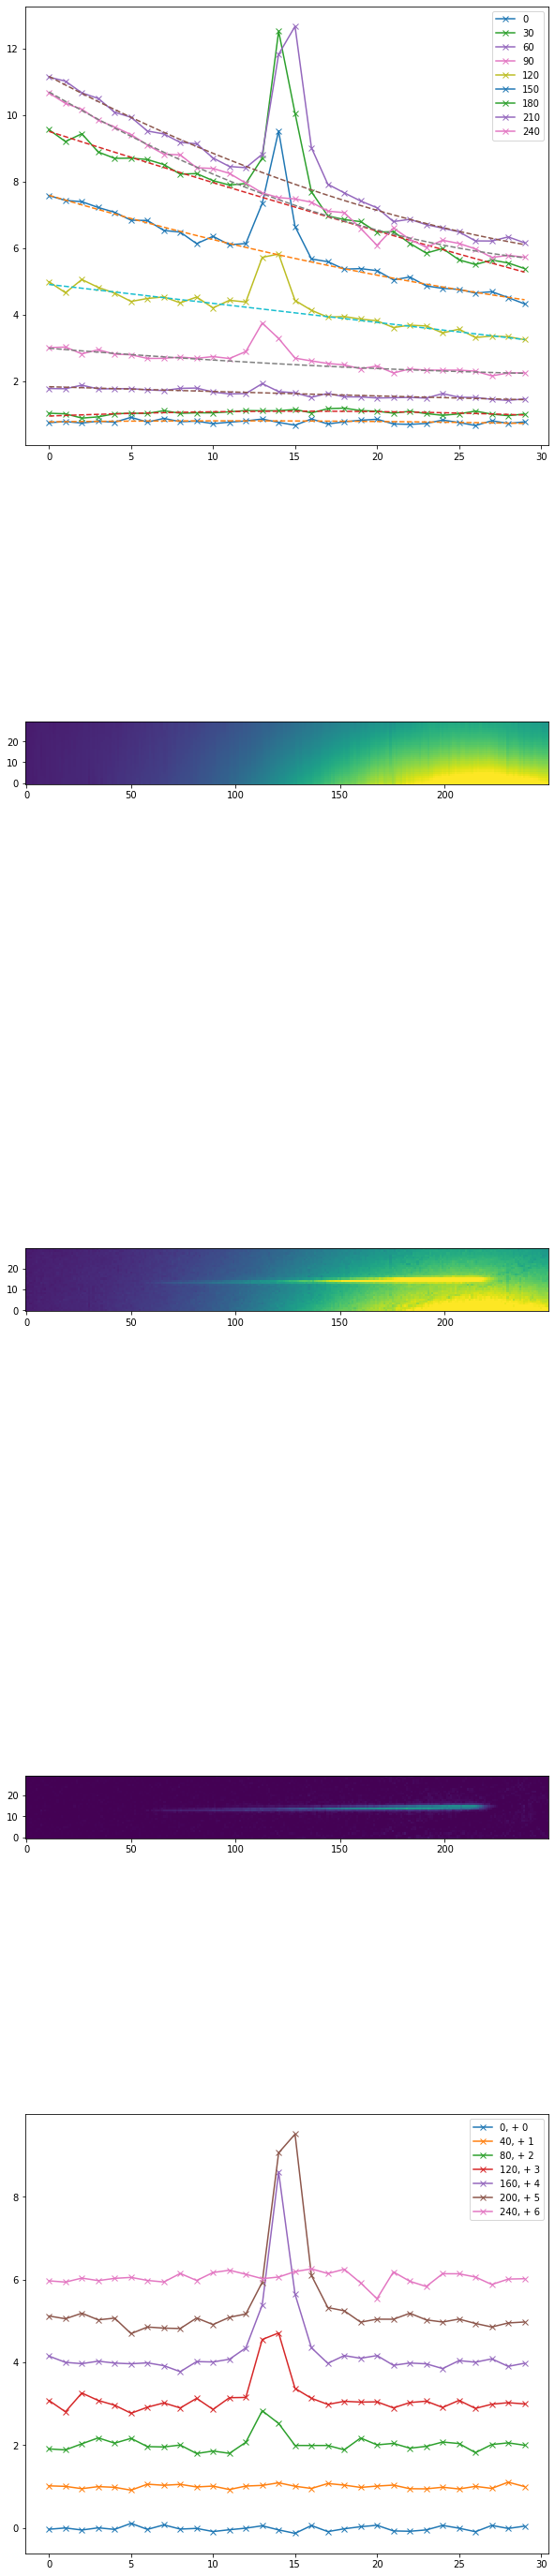

In [15]:
# simulate the backgroud model
n = 5
gmod = None
p = True
fig,ax = plt.subplots(n,1,figsize=(10,10*n))
for i in coef.keys():
    d = gxy[:,i]
    x = np.arange(gxy.shape[0])
    z = polynomial(x,*coef[i][0])
    
    if np.mod(i,30)==0:
        ax[0].plot(x,d,'x-',label=i)
        ax[0].plot(x,z,'--')

    z = [z]
    if p:
        gmod = z
        p = False
    else:
        gmod = np.concatenate([gmod,z])
ax[0].legend()

gmod = gmod.T
ax[1].imshow(gmod,cmap='viridis',origin='lower',vmin=0,vmax=10)

ax[2].imshow(gxy,cmap='viridis',origin='lower',vmin=0,vmax=10)

sxy = gxy - gmod
ax[3].imshow(sxy,cmap='viridis',origin='lower',vmin=0,vmax=10)

dd = 40
for i in np.arange(sxy.shape[1]):
    if np.mod(i,dd)==0:
        d = sxy[:,i]
#         d = d[mask_min:mask_max]
        ax[4].plot(d + np.int(i/dd),'x-',label='{0}, + {1}'.format(i,np.int(i/dd)))
ax[4].legend()

# Smoothing background model

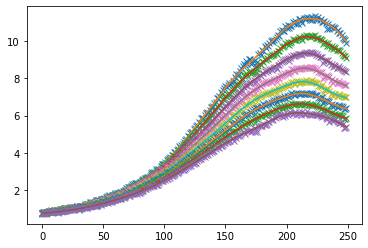

In [16]:
# smoothing background model with Savitzky-Golay filter
gmod_filter = np.full_like(gmod, fill_value=None, dtype=float)
for i in np.arange(gmod.shape[0]):
    x = scipy.signal.savgol_filter(gmod[i,:], 51, 3) # window size 51, polynomial order 3
    
    if np.mod(i,4)==0:
        plt.plot(gmod[i,:],'x')
        plt.plot(x,'-')
        
    gmod_filter[i,:] = x

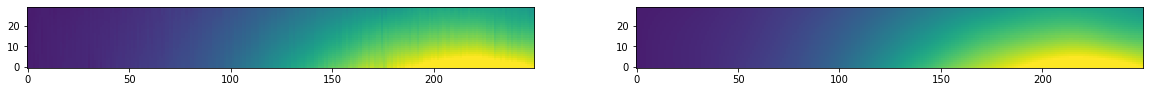

In [17]:
fig,ax = plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(gmod,cmap='viridis',origin='lower',vmin=0,vmax=10)
ax[1].imshow(gmod_filter,cmap='viridis',origin='lower',vmin=0,vmax=10)

In [18]:
gmod = gmod_filter
sxy = gxy - gmod

# Save output images

In [19]:
# save the background model, and extracted trace as extensions to the drizzled image
a = './170822/G102/g102_drz.fits'
x = fits.open(a)

x.append(fits.ImageHDU(name='BKG+TRA'))
x[5].header['NAME'] = ('Kornpob Bhirombhakdi', 'He added this extension.')
x[5].header['EXT'] = ('BKG+TRA', 'Stamp of background and spectral trace')
x[5].header['X0'] = ('{0}'.format(x0), 'x0 pixel in SCI image')
x[5].header['Y0'] = ('{0}'.format(y0), 'y0 pixel in SCI image')
x[5].header['DX'] = ('{0}'.format(dx), 'Stamp size in pixels')
x[5].header['DY'] = ('{0}'.format(dy), 'Stamp size in pixels')
x[5].data = gxy

x.append(fits.ImageHDU(name='BKG'))
x[6].header['NAME'] = ('Kornpob Bhirombhakdi', 'He added this extension.')
x[6].header['EXT'] = ('BKG', 'Background model')
x[6].header['MOD'] = ('A + Bx + Cx^2', 'Background model: 2nd-order polynomial')
x[6].header['DD'] = ('{0}'.format(dd), 'Mask thickness in pixels from y-center')
x[6].header['YA'] = ('{0}'.format(y_adjust), 'Arbitrary value for adjust the y-center of the mask')
x[6].header['YMIN'] = ('{0}'.format(mask_min), 'Min y-pixel for masking out: mask_min = dy-dd+ya')
x[6].header['YMAX'] = ('{0}'.format(mask_max), 'Max y-pixel for masking out: mask_max = dy+dd+ya')
x[6].data = gmod

x.append(fits.ImageHDU(name='TRA'))
x[7].header['NAME'] = ('Kornpob Bhirombhakdi', 'He added this extension.')
x[7].header['EXT'] = ('TRA', 'Spectral trace after background subtraction')
x[7].data = sxy

b = './170822/G102/g102_drz_sub.fits'
x.writeto(b, overwrite=True)
x.close()

# Fitting guassian trace

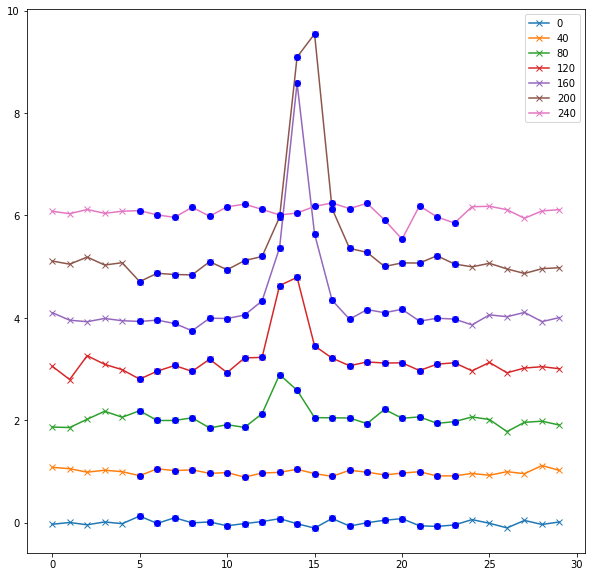

In [20]:
plt.figure(figsize=(10,10))
step = 40
ww = 5 # arbitrary width for adjusting input data for fitting
m_min = mask_min-ww
m_max = mask_max+ww+1
for i in np.arange(sxy.shape[1]):
    if np.mod(i,step)==0:
        d = sxy[:,i]
        x = np.arange(len(d))
        plt.plot(x,d + np.int(i/step),'x-',label=i)
        plt.plot(x[m_min:m_max],d[m_min:m_max] + np.int(i/step),'bo')
plt.legend()

In [21]:
init = [5.,dy+y_adjust,3.]
coefs = {}
for i in np.arange(sxy.shape[1]):
    if np.mod(i,1)==0:
        d = sxy[:,i]
        x = np.arange(len(d))
        popt,pcov = curve_fit(grismTrace, x[m_min:m_max], d[m_min:m_max]
                              , p0=init, maxfev=100000)
        coefs[i] = (popt,pcov)

/Users/kbhirombhakdi/anaconda2/envs/py3/lib/python3.6/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


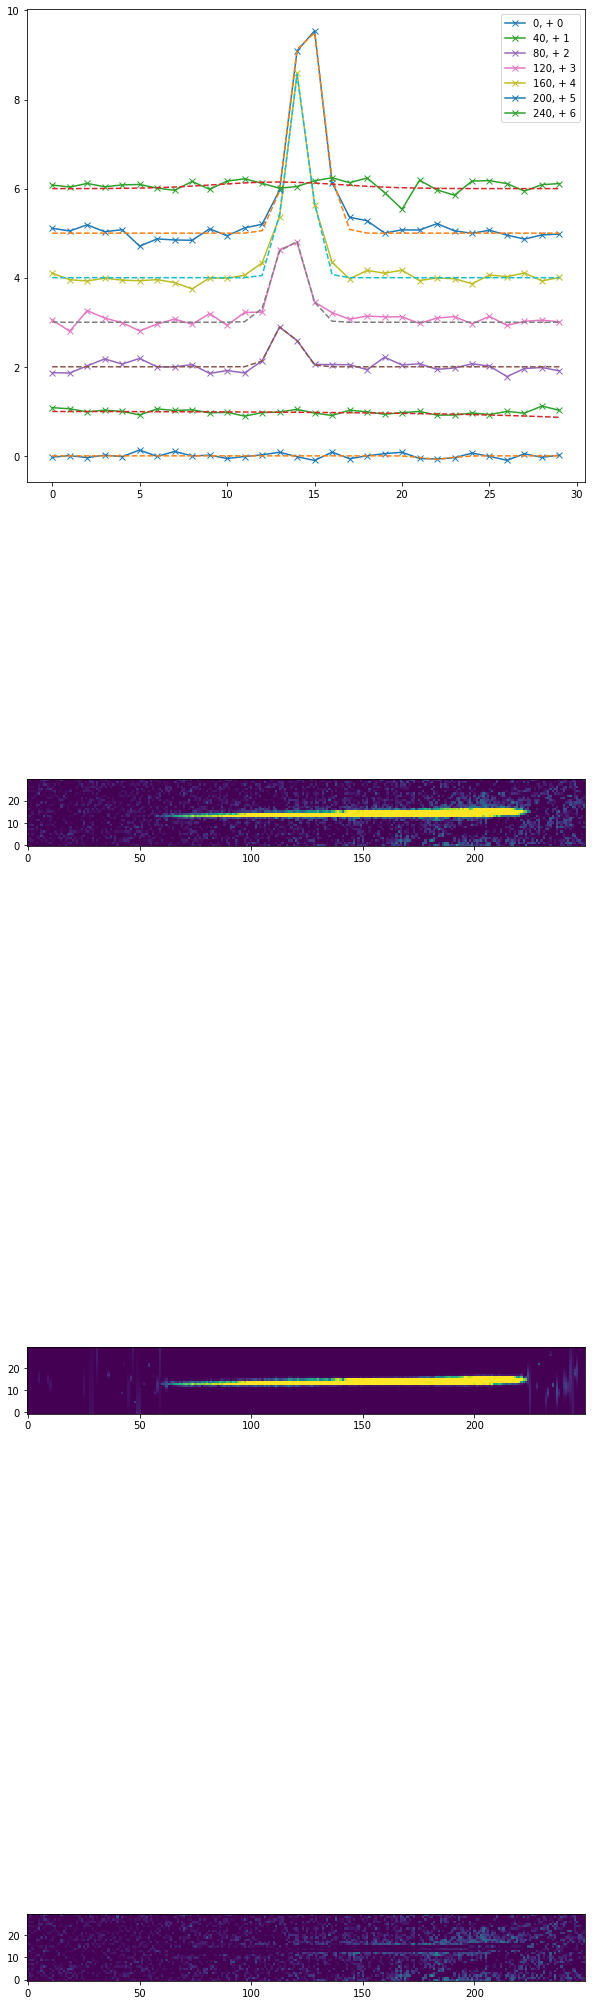

In [22]:
n = 4
fig,ax = plt.subplots(n,1,figsize=(10,10*n))
step = 40.
sfit = None
res = None
p = True
for i in coefs.keys():
    popt = coefs[i][0]
    d = sxy[:,i]
    x = np.arange(len(d))
    z = grismTrace(x,*popt)
    
    if np.mod(i,step)==0:
        ax[0].plot(x,d+np.int(i/step),'x-',label='{0}, + {1}'.format(i,np.int(i/step)))
        ax[0].plot(x,z+np.int(i/step),'--')
        
    z = [z]
    if p:
        sfit = z
        p = False
    else:
        sfit = np.concatenate([sfit,z])
ax[0].legend()

sfit = sfit.T
res = sxy-sfit
ax[1].imshow(sxy,cmap='viridis',origin='lower',vmin=0,vmax=1)
ax[2].imshow(sfit,cmap='viridis',origin='lower',vmin=0,vmax=1)
ax[3].imshow(res,cmap='viridis',origin='lower',vmin=0,vmax=1)

/Users/kbhirombhakdi/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.


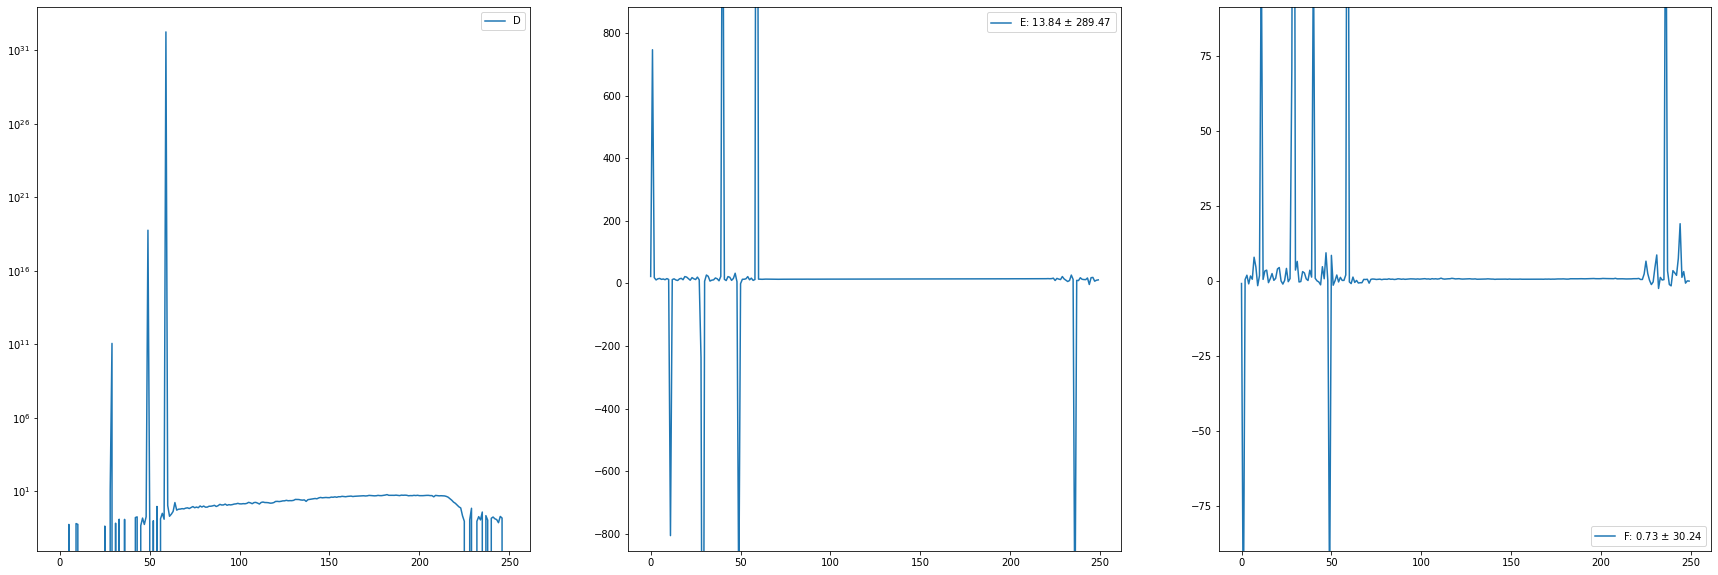

In [23]:
d,e,f=[],[],[]
dd,ee,ff=[],[],[]
for i in coefs:
    d.append(coefs[i][0][0]),dd.append(np.sqrt(coefs[i][1][0,0]))
    e.append(coefs[i][0][1])
    f.append(coefs[i][0][2])
x = np.arange(len(d))
d = np.array(d)
e = np.array(e)
f = np.array(f)

fig,ax = plt.subplots(1,3,figsize=(30,10))

ax[0].plot(x,d,label='D')
ax[0].legend()
ax[0].set_yscale('log')

med = np.median(e)
std = np.std(e)
ax[1].plot(x,e,label='E: {0:.2f} $\pm$ {1:.2f}'.format(med,std))
ax[1].set_ylim(med-std*3., med+std*3.)
ax[1].legend()
# ax[1].set_yscale('log')

med = np.median(f)
std = np.std(f)
ax[2].plot(x,f,label='F: {0:.2f} $\pm$ {1:.2f}'.format(med,std))
ax[2].set_ylim(med-std*3., med+std*3.)
ax[2].legend()

# Integrating fluxes

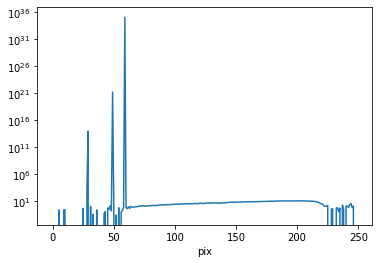

In [24]:
flam = {}
for i in coefs.keys():
    popt = coefs[i][0]
    x = totalGaussianFlux(*popt)
    flam[i] = x
    
plt.plot(list(flam.values()))
plt.xlabel('pix')
plt.yscale('log')

# Map pixels to wavelengths

In [25]:
beamfile='/Users/kbhirombhakdi/_work/h5axeconfig-master/h5axeconfig/data/hst_wfc3_ir_beams.h5'
grism='G102'
nx = 1014
conf=h5axeconfig.Camera(beamfile,grism)

xd=np.array([x0,x0,x0+1,x0+1],dtype=np.float)
yd=np.array([y0,y0+1,y0+1,y0],dtype=np.float)

<ErrorbarContainer object of 3 artists>

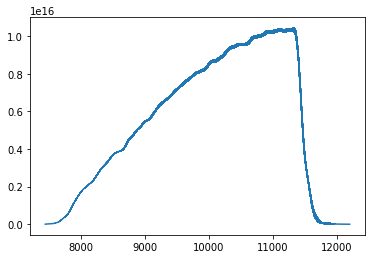

In [26]:
x = h5py.File(beamfile)
s = pd.DataFrame(x['G102']['IR']['A']['sensitivity'][:])
plt.errorbar(s['wavelength'],s['sensitivity'],s['error'])

In [27]:
dw = 25.
l=np.arange(np.min(s['wavelength']),np.max(s['wavelength']),dw)

In [28]:
for detname,detconf in conf:
    print(detconf)

Grism Detector calibration:
beam order
   A     1
   B     0
   C     2
   D     3
   E    -1



760 760 760 760 760 190


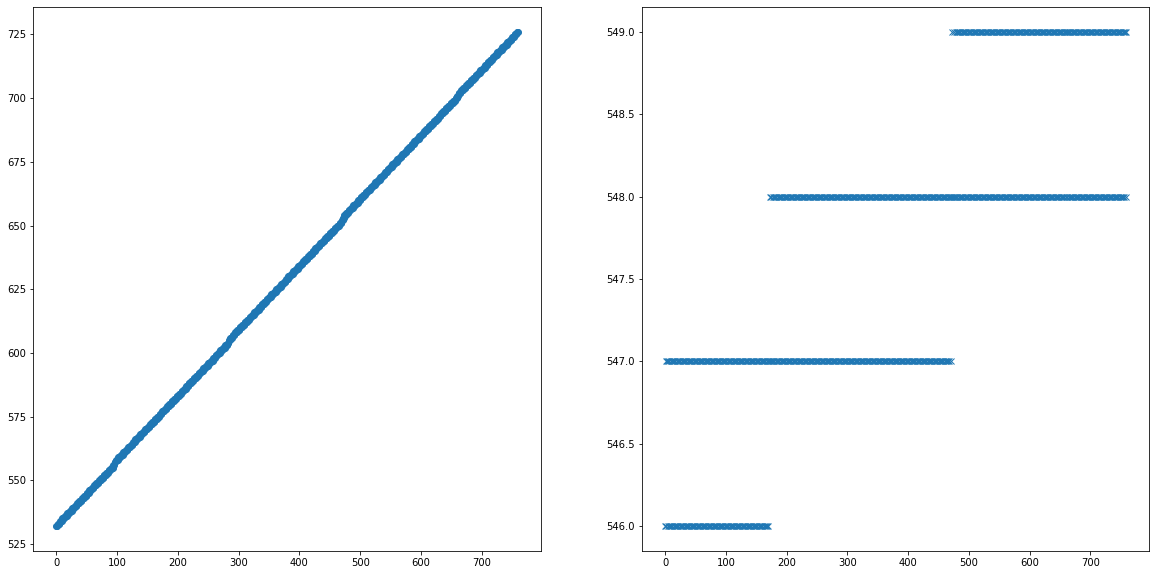

In [29]:
for detname,detconf in conf:
    for beamname,beamconf in detconf:
        if beamname=='A':
            xg,yg = beamconf.xyd2xyg(xd,yd,l)
            
            xyg,lam,val = beamconf.specDrizzle(xd,yd,l)
            if len(xyg)!=0:
                yl,xl=np.divmod(xyg,nx)

print(len(xl),len(yl),len(xyg),len(lam),len(val),len(l))

fig,ax = plt.subplots(1,2,figsize=(20,10))
ax[0].plot(xl,'o-')
ax[1].plot(yl,'x')
plt.show()

In [30]:
lam = np.array(lam)
xl = np.array(xl)
val = np.array(val)
out = []
for i in np.arange(len(l)):
    m = np.argwhere(lam==i).flatten()
    x = xl[m]
    v = val[m]
    ss = 0.
    for j in np.arange(len(x)):
        jj = np.int(x[j] - x0)
        ss = ss + flam[jj] * v[j]
    ss = ss / np.sum(v)
    out.append(ss)
out = np.array(out)

In [31]:
sense,e_sense = [],[]
for i in l:
    x = np.asscalar(np.argwhere(s['wavelength']==i))
    sense.append(s.iloc[x][1])
    e_sense.append(s.iloc[x][2])
sense = np.array(sense)
e_sense = np.array(sense)

/Users/kbhirombhakdi/anaconda2/envs/py3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)


/Users/kbhirombhakdi/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
/Users/kbhirombhakdi/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in true_divide


(997.5884463142932, 4987.9422315714655)

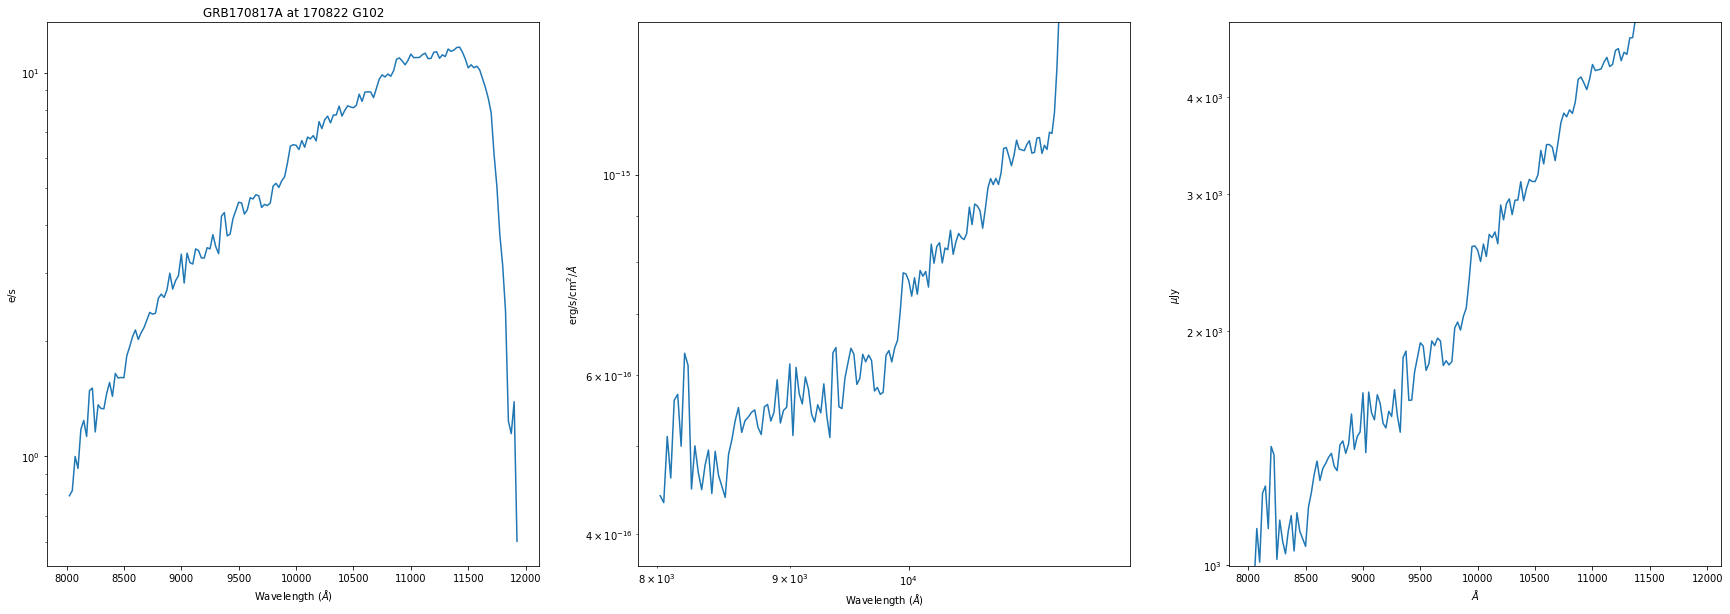

In [32]:
fig,ax = plt.subplots(1,3,figsize=(30,10))

m = np.argwhere(l > 8000.).flatten()
m = np.intersect1d(m,np.argwhere(l < 12000.).flatten())
m = np.intersect1d(m,np.argwhere(out > 0.).flatten())

ax[0].plot(l[m],out[m])
ax[0].set_xlabel('Wavelength ($\AA$)')
ax[0].set_ylabel('e/s')
ax[0].set_title('GRB170817A at 170822 G102')
ax[0].set_yscale('log')

flam = out/sense
ax[1].plot(l[m],flam[m])
ax[1].set_xlabel('Wavelength ($\AA$)')
ax[1].set_ylabel('erg/s/cm$^2$/$\AA$')
ax[1].set_yscale('log')
med = np.median(flam[m])
ax[1].set_ylim(med*0.5, med*2.)
ax[1].set_xscale('log')

fnu = l*l*out/sense/3e-11
ax[2].plot(l[m],fnu[m])
ax[2].set_ylabel('$\mu$Jy')
ax[2].set_xlabel('$\AA$')
ax[2].set_yscale('log')
med = np.median(fnu[m])
ax[2].set_ylim(med*0.4, med*2.)

In [35]:
a = './170822/G102/g102_spec.dat'
file = open(a,'w') 
file.write('# GRB170817A, 170822, G102 \n')
file.write('# Wavelength (A) \n')
file.write('# Count rate (e/s) \n')
file.write('# Sensitivity (e/s per erg/s/cm^2/A) \n')
file.write('# flam (erg/s/cm^2/A) \n')
file.write('# fnu (uJy) \n')
for i in np.arange(len(l)):
    file.write('{0:.3E} {1:.3E} {2:.3E} {3:.3E} {4:.3E} \n'.format(l[i],out[i],sense[i],flam[i],fnu[i]))
file.close() 

# Photometry

In [34]:
# 4.79d, F110W, 18.26 +- 0.01, Tanvir et al. 2017
# F110W, 11534 +- 4430 A
def mag2flux(mag,ABwave):
    return 10**(-0.4 * (mag + 2.406 + 5 * np.log10(ABwave))) # erg/s/cm^2/A

x = mag2flux(18.26, 11534.)
x

4.0704282694269805e-17